#### Creating a Spark session

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
spark = SparkSession.builder.master("local[*]").appName("CrimeInvestigation").getOrCreate();

#### Defining the schema for loading the Chicago crime dataset

In [2]:
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)
data = sqlContext.read.load("Crimes_-_2001_to_Present.csv", format="com.databricks.spark.csv", header= 'true', inferSchema= 'true', nullvalue = 'NA')

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



#### Cleaning the data

In [4]:
from pyspark.sql.functions import col
df = data.withColumn("Date",col("Date").cast(DateType()))
df.printSchema()
df = data.dropna()
df.show()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

+--------+-----------+--------------------+--------------------+----+---------------+-------------

#### Filter the data for last ten years

In [5]:
df3 = df.filter(df.Date >= "10/10/2012")
df3.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11859805|   JC471592|10/13/2019 08:30:...| 024XX W CHICAGO AVE|0860|               THEFT|        RETAIL THEFT|  GROCERY FOO

#### Removing all the records with the following crime types:
#### 'NON-CRIMINAL (SUBJECT SPECIFIED)'
#### 'OTHER OFFENSE'
#### 'STALKING'
#### 'NON - CRIMINAL'
#### 'ARSON'

In [6]:
df4=df3[df3['Primary Type'] != 'OTHER OFFENSE']
df5=df4[df4['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']
df6=df5[df5['Primary Type'] != 'STALKING']
df7=df6[df6['Primary Type'] != 'NON - CRIMINAL']
df8=df7[df7['Primary Type'] != 'ARSON']
df8.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11859805|   JC471592|10/13/2019 08:30:...| 024XX W CHICAGO AVE|0860|               THEFT|        RETAIL THEFT|  GROCERY FOO

#### Merging the similar crime types

In [7]:
df8=df7.replace("PROSTITUTION", "SEX OFFENSE")
df9=df8.replace("CRIM SEXUAL ASSAULT", "CRIMINAL SEXUAL ASSAULT")
df10=df9.replace("CRIMINAL SEXUAL ASSAULT", "SEX OFFENSE")
df11=df10.replace("BURGLARY", "THEFT")
df12=df11.replace("ROBBERY", "THEFT")
df13=df12.replace("OTHER NARCOTIC VIOLATION", "NARCOTICS")

#### Analyze the data and present results:
#### Show year-wise trend of the crime for last ten years.
#### Find out at which hour of the day crime is highest.
#### Find top ten crimes and present them as a bar chart.

In [8]:
yearly_crimes = df13.groupBy("Year").count().orderBy('Year')
yearly_crimes.show()

+----+-----+
|Year|count|
+----+-----+
|2001| 1132|
|2002|93547|
|2003|96084|
|2004|92985|
|2005|88970|
|2006|89281|
|2007|86757|
|2008|81785|
|2009|76082|
|2010|71372|
|2011|70784|
|2012|67296|
|2013|59288|
|2014|54827|
|2015|52273|
|2016|54540|
|2017|53702|
|2018|53172|
|2019|51633|
|2020|42153|
+----+-----+
only showing top 20 rows



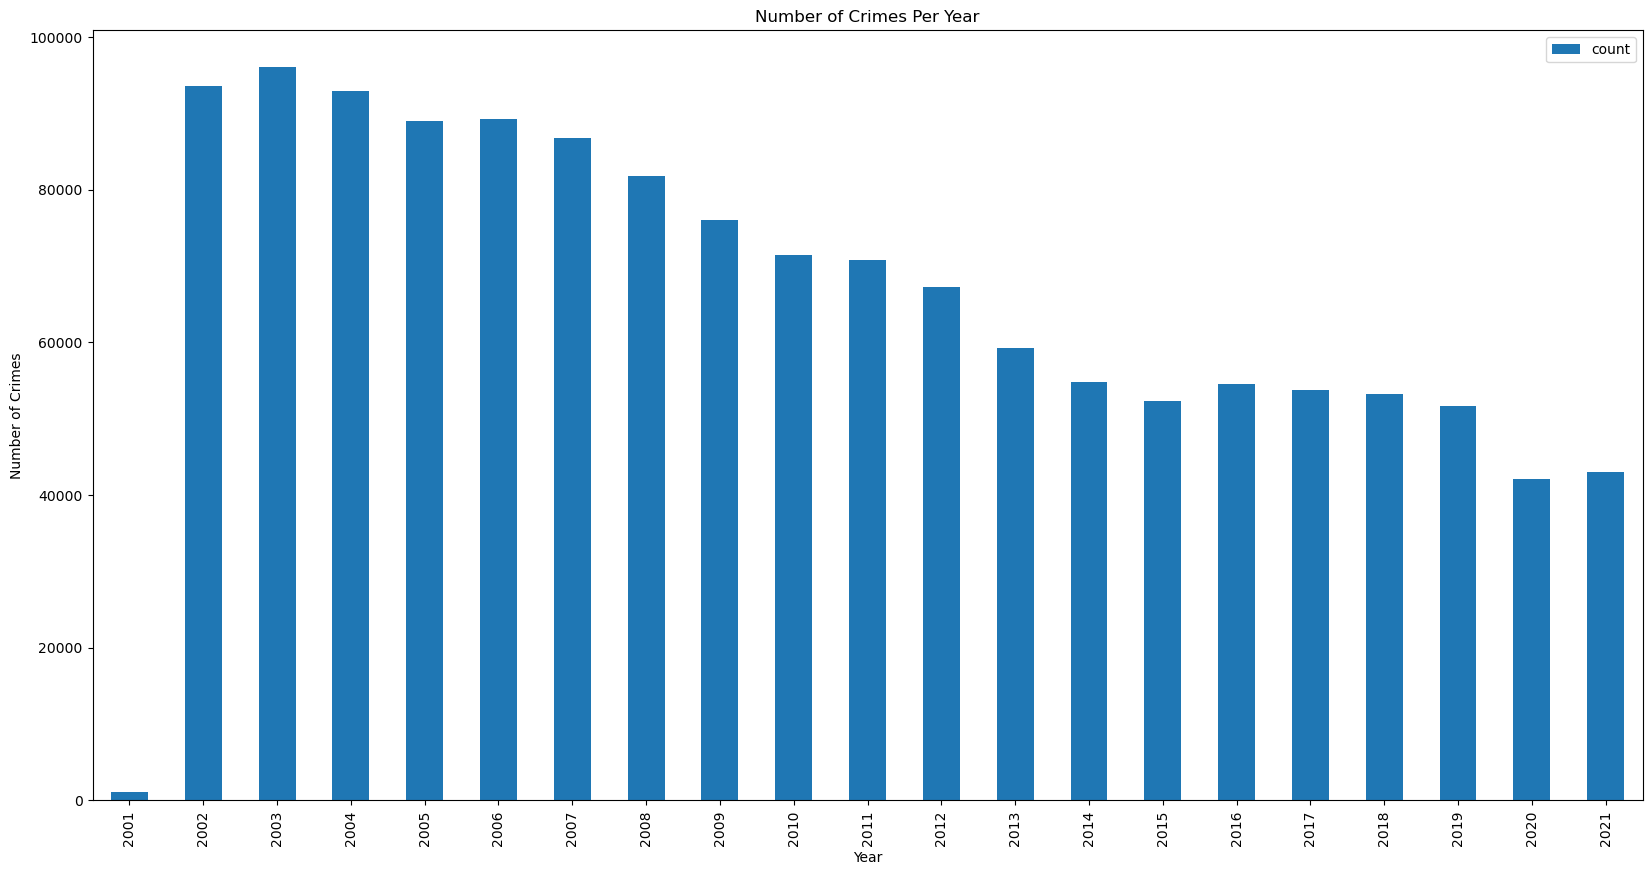

In [9]:
import matplotlib.pyplot as plt
YearlyCrimes_Trend = yearly_crimes.toPandas()
YearlyCrimes_Trend.plot(figsize = (20,10), kind = "bar", x = "Year", y = "count")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes Per Year")
plt.show()

In [10]:
import datetime
from pyspark.sql.functions import *
df14 = df13.withColumn('date_time', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY'))

In [11]:
df_hours = df14.withColumn('hour', hour(df14['date_time']))

In [12]:
hours = df_hours.groupBy(['Primary Type', 'hour']).count().cache()
hours_count = hours.groupBy('hour').sum('count')
hours_count.show()

# Here we can see that between 18-22 hours the crime count is highest

+----+----------+
|hour|sum(count)|
+----+----------+
|  23|     59232|
|  11|     63056|
|  14|     71812|
|  12|     79700|
|  22|     71514|
|  18|     76974|
|   1|     41929|
|   6|     21952|
|  20|     78756|
|   9|     59621|
|  17|     72070|
|  10|     58698|
|   3|     28487|
|  19|     79797|
|   2|     35152|
|   0|     71830|
|  16|     71493|
|   5|     18673|
|   4|     21659|
|  21|     74393|
+----+----------+
only showing top 20 rows



In [13]:
Top_10_crimes = df14.groupBy(['Primary Type']).count().orderBy('count', ascending=False)

In [14]:
Top_10_crimes.head(10)

[Row(Primary Type='THEFT', count=474473),
 Row(Primary Type='BATTERY', count=254158),
 Row(Primary Type='CRIMINAL DAMAGE', count=170441),
 Row(Primary Type='NARCOTICS', count=139983),
 Row(Primary Type='ASSAULT', count=88647),
 Row(Primary Type='MOTOR VEHICLE THEFT', count=71418),
 Row(Primary Type='DECEPTIVE PRACTICE', count=64754),
 Row(Primary Type='CRIMINAL TRESPASS', count=41227),
 Row(Primary Type='SEX OFFENSE', count=22776),
 Row(Primary Type='WEAPONS VIOLATION', count=18940)]

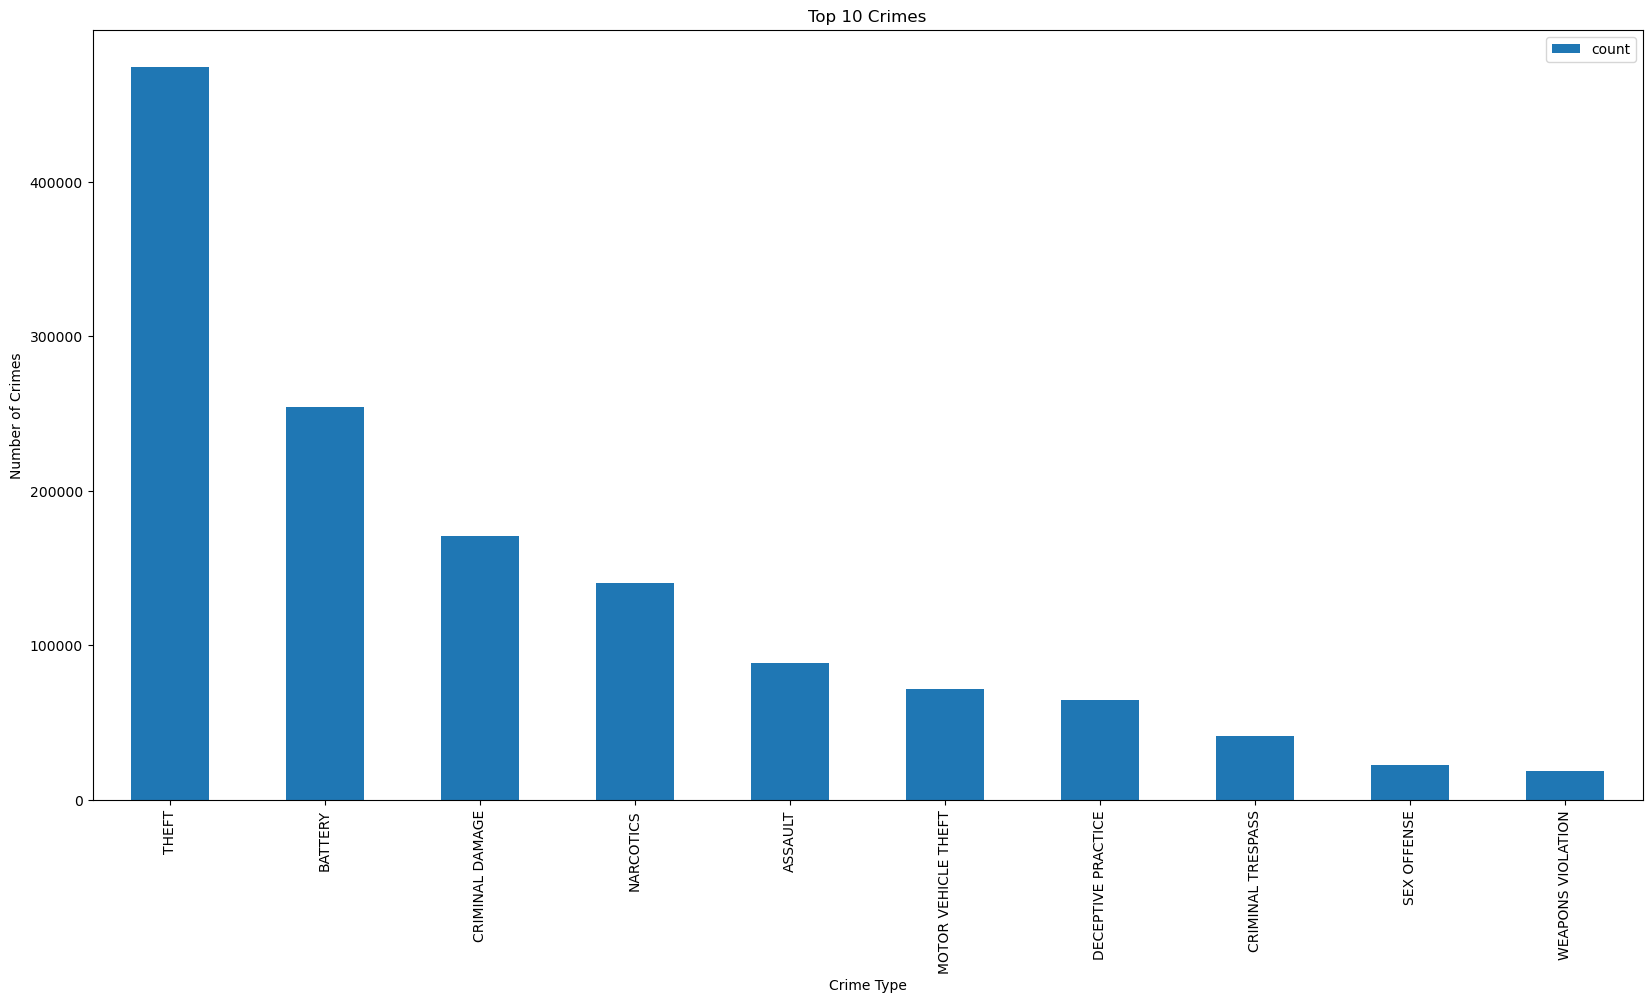

In [15]:
Top_10_Crimes=Top_10_crimes.toPandas()
Top10=Top_10_Crimes.head(10)
Top10.plot(figsize = (20,10), kind = "bar", x = "Primary Type", y = "count")
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.title("Top 10 Crimes")
plt.show()